C:\Users\Henry\miniconda3\lib\site-packages\matplotlib\collections.py:1003: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


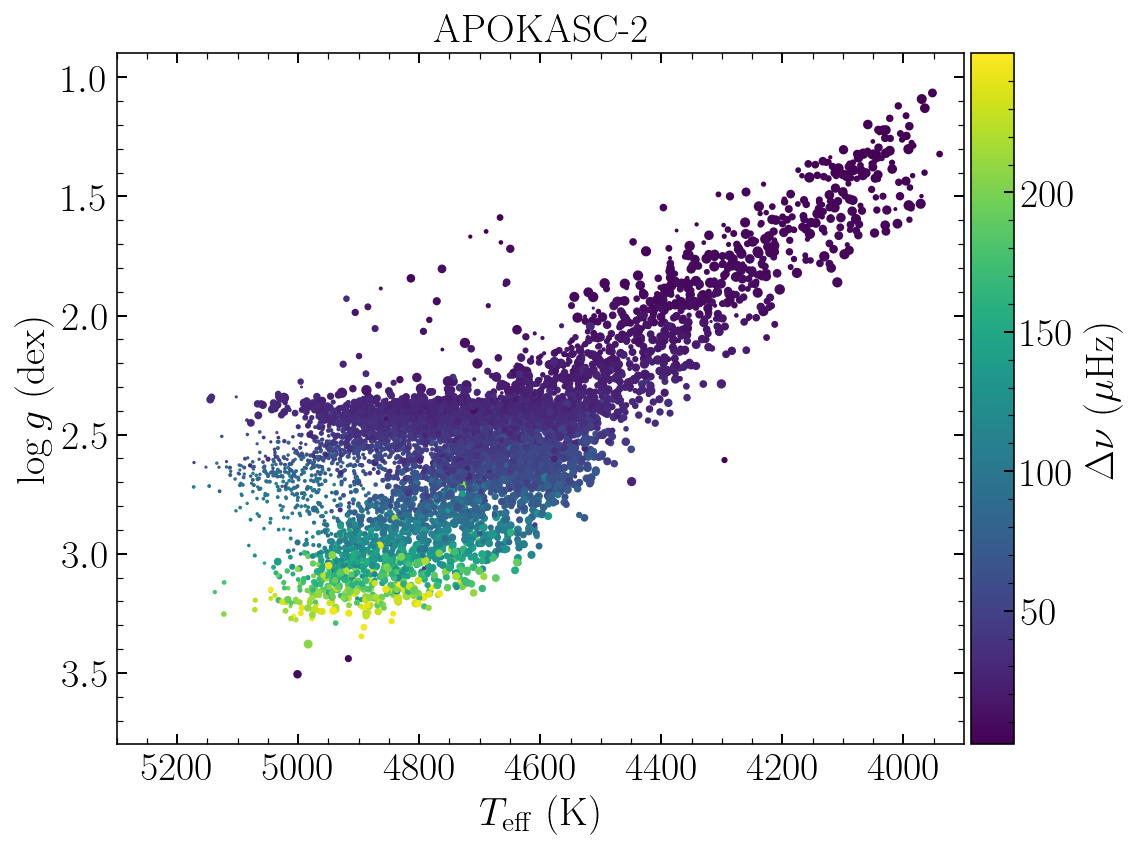

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import h5py
import numpy as np
import pylab as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astroNN.shared.matplotlib import pylab_style
import mesa_reader as mr

pylab_style(paper=True)

h5f = h5py.File("../APOKASC2.h5", "r")

h = mr.MesaData('1M_evo_track.data')
mesa_temperatures = 10 ** h.log_Teff
mesa_logg = h.log_g
star_age = h.star_age / 10 ** 9

numax = np.array(h5f["Numax"])
deltanu = np.array(h5f["Deltanu"])
es = np.array(h5f["ES"]).astype("str")
teff = np.array(h5f["TEFF"])
logg = np.array(h5f["LOGG"])
Mcorr = np.array(h5f["Mcorr"])
Rcorr = np.array(h5f["Rcorr"])
age = np.array(h5f["Age"])

good_idx = (numax != -9999.0) & (deltanu != -9999.0)

fig = plt.figure(figsize=(8., 6.))
ax = plt.gca()
ax.set_xlim([5300, 3900])
ax.set_ylim([3.8, 0.9])
mappable = ax.scatter(teff[good_idx], logg[good_idx], c=numax[good_idx], s=(age)[good_idx], rasterized=True)
# ax.scatter(mesa_temperatures, mesa_logg, c=star_age, s=1, vmin=12, vmax=13, cmap="coolwarm")
ax.set_title("APOKASC-2")
ax.set_xlabel(r"$T_\mathrm{eff}\ (\mathrm{K})$")
ax.set_ylabel(r"$\log{g}\ (\mathrm{dex})$")
# ax.minorticks_on()
# ax.tick_params(labelsize=19, width=2, length=15, which="major")
# ax.tick_params(width=1, length=7.5, which="minor")
# ax.legend(loc="upper right", markerscale=3)
# colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(cax=cax, mappable=mappable)
cbar.ax.tick_params()
cbar.set_label(r"$\Delta{\nu}\ (\mu \mathrm{Hz})$")
plt.tight_layout()
plt.savefig("apokasc.pdf")

In [ ]:
import h5py
import numpy as np
from tqdm import tqdm
import lightkurve as lk
import astropy.units as u
from astropy.io import fits
from astroNN.apogee import allstar
from astropy.timeseries import LombScargle
from lightkurve.units import ppm
import pylab as plt


h5f = h5py.File("APOKASC2.h5", "r")
lc_h5f = h5py.File("APOKASC2_powerspec.h5", "r")
all_acf = np.zeros((len(h5f["KIC"]), 4000))
allstar_f = fits.getdata(allstar(dr=17))[h5f["allstar_dr17_idx"]]
contspec = fits.getdata("../contspec_dr17_synspec.fits")[h5f["allstar_dr17_idx"]]

h5f_3P = h5py.File("APOKASC3P.h5", "r")
lc_h5f_3P = h5py.File("APOKASC3P_powerspec.h5", "r")
all_acf_3P = np.zeros((len(h5f_3P["KIC"]), 4000))
allstar_f_3P = fits.getdata(allstar(dr=17))[h5f_3P["allstar_dr17_idx"]]
contspec_3P = fits.getdata("../contspec_dr17_synspec.fits")[h5f_3P["allstar_dr17_idx"]]

for i in tqdm(range(len(h5f["KIC"]))):
    flatten_power = lc_h5f["powerspec"][i]
    A = flatten_power
    c_fourier = np.fft.ifft(A)
    all_acf[i] = np.abs(c_fourier[: (c_fourier.size // 2) + 1][0:4000])

for i in tqdm(range(len(h5f_3P["KIC"]))):
    flatten_power = lc_h5f_3P["powerspec"][i]
    A = flatten_power
    c_fourier = np.fft.ifft(A)
    all_acf_3P[i] = np.abs(c_fourier[: (c_fourier.size // 2) + 1][0:4000])

100%|██████████| 18452/18452 [00:24<00:00, 754.26it/s]


In [ ]:
from astroNN.models import ApogeeCNN
from astroNN.nn.callbacks import ErrorOnNaN


good_idx = (h5f["Numax"][()] > 0) & (h5f["Deltanu"][()] > 0)
good_idx = (h5f["Numax"][()] > 0) & (h5f["Deltanu"][()] > 0) & (h5f["Age"][()] > 0)
good_idx_3P = (h5f_3P["Numax"][()] > 0) & (h5f_3P["Deltanu"][()] > 0)

inputs = all_acf[good_idx]
inputs_spec = contspec[good_idx]
inputs_3P = all_acf_3P[good_idx_3P]
inputs_spec_3P = contspec_3P[good_idx_3P]

labels = np.stack(
    [
        h5f["Numax"][()][good_idx],
        h5f["Deltanu"][()][good_idx],
        h5f["Age"][()][good_idx],
        allstar_f["M_H"][good_idx],
        h5f["Mass"][()][good_idx],
        h5f["R"][()][good_idx],
    ]
).T

labels_3P = np.stack(
    [
        h5f_3P["Numax"][()][good_idx_3P],
        h5f_3P["Deltanu"][()][good_idx_3P],
        np.ones_like(h5f_3P["Deltanu"][()][good_idx_3P]) * -9999.,
        allstar_f_3P["M_H"][good_idx_3P],
        h5f_3P["Mass"][()][good_idx_3P],
        h5f_3P["R"][()][good_idx_3P],
    ]
).T

inputs_combined = np.concatenate([inputs, inputs_3P])
inputs_spec_combined = np.concatenate([inputs_spec, inputs_spec_3P])
labels_combined = np.concatenate([labels, labels_3P])

nn = ApogeeCNN()
nn.max_epochs = 30
nn.dropout_rate = 0.2
nn.callbacks = ErrorOnNaN()
nn.fit(inputs_combined, labels_combined)

nn2 = ApogeeCNN()
nn2.max_epochs = 30
nn2.dropout_rate = 0.2
nn2.callbacks = ErrorOnNaN()
nn2.fit(inputs_spec_combined, labels_combined)

age_predict = nn.predict(inputs_combined[nn.val_idx])
age_predict2 = nn2.predict(inputs_spec_combined[nn2.val_idx])

Number of Training Data: 17710, Number of Validation Data: 1967
====Message from Normalizer==== 
 You selected mode: 3 
 Featurewise Center: {'input': True} 
 Datawise Center: {'input': False} 
 Featurewise std Center: {'input': False} 
 Datawise std Center: {'input': False} 
 ====Message ends====
====Message from Normalizer==== 
 You selected mode: 2 
 Featurewise Center: {'output': True} 
 Datawise Center: {'output': False} 
 Featurewise std Center: {'output': True} 
 Datawise std Center: {'output': False} 
 ====Message ends====
Epoch 1/30
276/276 - 9s - loss: 3.2514 - mean_absolute_error: 0.7039 - mean_error: -2.8809e-03 - val_loss: 0.9346 - val_mean_absolute_error: 0.6600 - val_mean_error: -2.0033e-02 - lr: 0.0050 - 9s/epoch - 32ms/step
Epoch 2/30
276/276 - 4s - loss: 1.0428 - mean_absolute_error: 0.6828 - mean_error: 0.0017 - val_loss: 0.9337 - val_mean_absolute_error: 0.6654 - val_mean_error: -2.9460e-02 - lr: 0.0050 - 4s/epoch - 16ms/step
Epoch 3/30
276/276 - 4s - loss: 1.2673 -

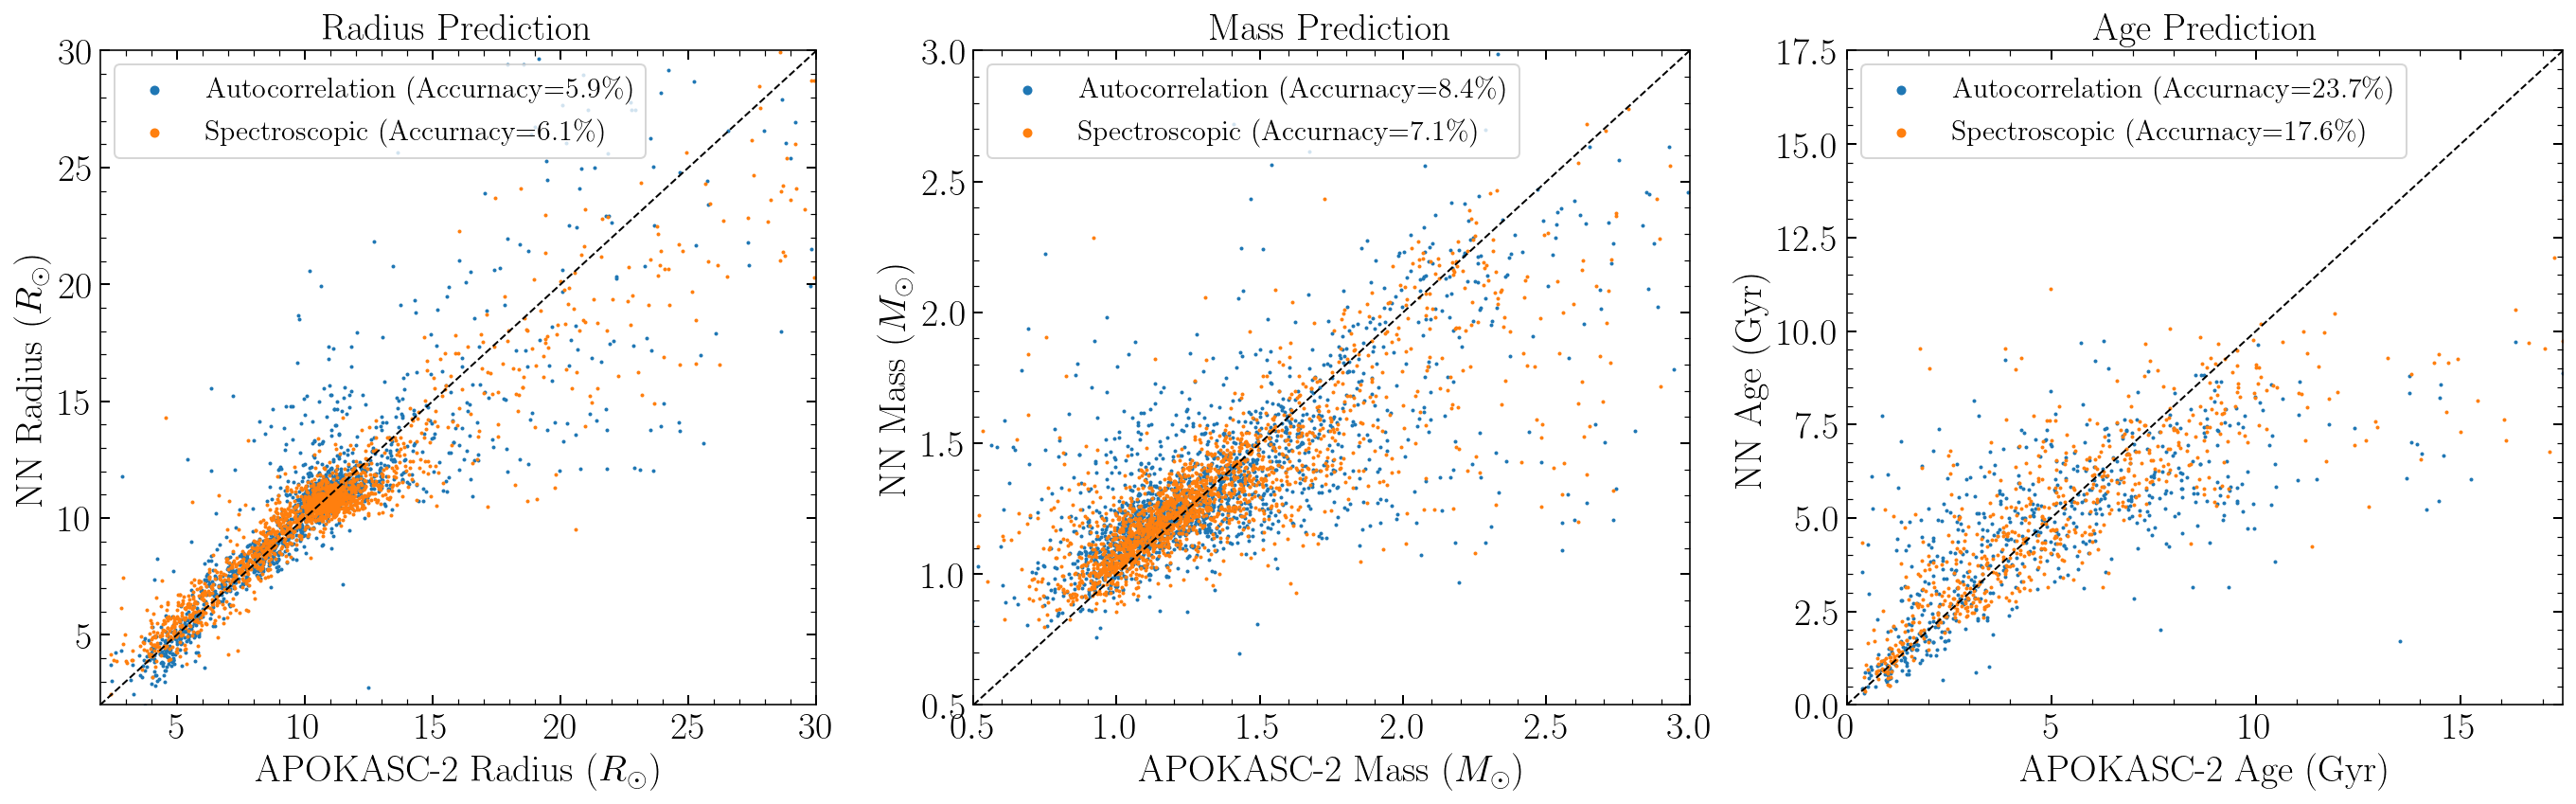

In [ ]:
from astroNN.shared.matplotlib import pylab_style

pylab_style(paper=True)

fig, (ax3, ax1, ax2) = plt.subplots(1, 3, figsize=(19, 6))

a = np.median(np.abs(age_predict[:, 5] - labels_combined[nn.val_idx][:, 5]) / labels_combined[nn.val_idx][:, 5])
s = np.median(np.abs(age_predict2[:, 5] - labels_combined[nn2.val_idx][:, 5]) / labels_combined[nn2.val_idx][:, 5])
ax3.set_title("Radius Prediction")
ax3.scatter(labels_combined[nn.val_idx][:, 5], age_predict[:, 5], s=1, label=f"Autocorrelation (Accurnacy=${{{a*100:.1f}}}\%)$")
ax3.scatter(labels_combined[nn2.val_idx][:, 5], age_predict2[:, 5], s=1, label=f"Spectroscopic (Accurnacy=${{{s*100:.1f}}}\%$)")
ax3.set_xlabel(r"APOKASC-2 Radius ($R_\odot$)")
ax3.set_ylabel(r"NN Radius ($R_\odot$)")
ax3.plot([2, 30.], [2., 30.], c="k", ls="--")
ax3.set_xlim(2., 30.)
ax3.set_ylim(2., 30.)
ax3.legend(loc="upper left", markerscale=4.)

a = np.median(np.abs(age_predict[:, 4] - labels_combined[nn.val_idx][:, 4]) / labels_combined[nn.val_idx][:, 4])
s = np.median(np.abs(age_predict2[:, 4] - labels_combined[nn2.val_idx][:, 4]) / labels_combined[nn2.val_idx][:, 4])
ax1.set_title("Mass Prediction")
ax1.scatter(labels_combined[nn.val_idx][:, 4], age_predict[:, 4], s=1, label=f"Autocorrelation (Accurnacy=${{{a*100:.1f}}}\%)$")
ax1.scatter(labels_combined[nn2.val_idx][:, 4], age_predict2[:, 4], s=1, label=f"Spectroscopic (Accurnacy=${{{s*100:.1f}}}\%$)")
ax1.set_xlabel(r"APOKASC-2 Mass ($M_\odot$)")
ax1.set_ylabel(r"NN Mass ($M_\odot$)")
ax1.plot([0.5, 3.], [0.5, 3.], c="k", ls="--")
ax1.set_xlim(0.5, 3.)
ax1.set_ylim(0.5, 3.)
ax1.legend(loc="upper left", markerscale=4.)

a = np.median((np.abs(age_predict[:, 2] - labels_combined[nn.val_idx][:, 2]) / labels_combined[nn.val_idx][:, 2])[labels_combined[nn.val_idx][:, 2]>0])
s = np.median((np.abs(age_predict2[:, 2] - labels_combined[nn2.val_idx][:, 2]) / labels_combined[nn2.val_idx][:, 2])[labels_combined[nn2.val_idx][:, 2]>0])
ax2.set_title("Age Prediction")
ax2.scatter(labels_combined[nn.val_idx][:, 2], age_predict[:, 2], s=1, label=f"Autocorrelation (Accurnacy=${{{a*100:.1f}}}\%)$")
ax2.scatter(labels_combined[nn2.val_idx][:, 2], age_predict2[:, 2], s=1, label=f"Spectroscopic (Accurnacy=${{{s*100:.1f}}}\%)$")
ax2.set_xlabel("APOKASC-2 Age (Gyr)")
ax2.set_ylabel("NN Age (Gyr)")
ax2.plot([0., 17.5], [0., 17.5], c="k", ls="--")
ax2.set_xlim(0., 17.5)
ax2.set_ylim(0., 17.5)
ax2.legend(loc="upper left", markerscale=4.)
fig.tight_layout()
fig.savefig("ages_prediction.pdf")